# Integrate and plot sound, environmental, and climatology data

In [64]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr

In [65]:
# Supress warnings
warnings.filterwarnings('ignore')

In [66]:
%matplotlib inline

# Clear out default notebook settings
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Set figure size and layout
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True

## Read in and clean up sound data

In [67]:
# Define file paths -- can be a string glob or list of explicit paths
paths = '/home/jovyan/depot/SB03/SB03*.nc'

In [68]:
# Read in data, dropping variables that are sometimes inconsistent across files to 
# prevent open_mfdataset from complaining
sound_ds =  xr.open_mfdataset(
    paths,
    drop_variables=['psd_image_colormap', 'psd_image', 'percentile_image','percentile_image_colormap']
)

In [69]:
# Remove data flagged as low quality
sound_ds = sound_ds.where(sound_ds.quality_flag == 1, drop=True)
sound_ds

<xarray.Dataset>
Dimensions:             (time: 95340, frequency: 2157, cal_frequency: 3206)
Coordinates:
  * time                (time) datetime64[ns] 2020-01-31T19:00:00 ... 2020-04...
  * frequency           (frequency) float64 21.0 22.0 23.0 ... 2.396e+04 2.4e+04
  * cal_frequency       (cal_frequency) float64 0.0 1.0 ... 2.556e+05 2.56e+05
Data variables:
    timestamp           (time, frequency) timedelta64[ns] dask.array<chunksize=(300, 2157), meta=np.ndarray>
    effort              (time, frequency) timedelta64[ns] dask.array<chunksize=(300, 2157), meta=np.ndarray>
    psd                 (time, frequency) float64 dask.array<chunksize=(300, 2157), meta=np.ndarray>
    quality_flag        (time, frequency) float64 dask.array<chunksize=(300, 2157), meta=np.ndarray>
    analog_sensitivity  (time, cal_frequency, frequency) float64 dask.array<chunksize=(300, 3206, 2157), meta=np.ndarray>
    preamp_gain         (time, cal_frequency, frequency) float64 dask.array<chunksize=(300, 3206, 2157), meta=np.ndarray>
    recorder_gain       (time, cal_frequency, frequency) float64 dask.array<chunksize=(300, 3206, 2157), meta=np.ndarray>
    sensor_sensitivity  (time, cal_frequency, frequency) float64 dask.array<chunksize=(300, 3206, 2157), meta=np.ndarray>
Attributes: (12/32)
    acknowledgement:                             These products support the P...
    comment:                                     Data quality: Good 2020-01-3...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Timothy Rowell, Megan McKenna
    creator_role:                                Principal Investigator
    date_created:                                2023-07-15
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                48000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:                             1970-01-01 00:00:00

## Download and wrangle environmental data

In [92]:
erddap_base_url = 'https://erddap.sensors.ioos.us/erddap'
# erddap_dataset = 'wmo_44013' # SB03- Y
erddap_dataset = 'wmo_46069' # CI04
#erddap_dataset = 'university_of_georgia_uga_41008' # GR01
#erddap_dataset = 'org_pacioos_51208' # HI04,--- no wind data
#erddap_dataset = 'edu_ucsd_cdip_46240' # MB02,--- no wind data
#erddap_dataset = 'wmo_46087' # OC02
#erddap_dataset = 'noaa_nos_co_ops_1619910' # PM08--- no wind data

# Grab the same time range covered by the sound data
time_start ='2018-12-31T23:59:00.000000000'
time_end =  '2021-12-31T23:59:00.000000000'

# time_start = np.datetime_as_string(sound_ds.time.min().to_pandas())
# time_end = np.datetime_as_string(sound_ds.time.max().to_pandas())

wind_var = 'wind_speed'
swt_var = 'sea_water_temperature'
wave_var = 'sea_surface_wave_significant_height'
anomaly_var = 'swt_anomaly'

#erddap_dataset_url = (
#    f'{erddap_base_url}/tabledap/{erddap_dataset}.csv'
#    f'?time,{wind_var},{swt_var},{wave_var}&time>={time_start}&time<={time_end}'
# )

erddap_dataset_url = (
    f'{erddap_base_url}/tabledap/{erddap_dataset}.csv'
    f'?time,{wind_var}&time>={time_start}&time<={time_end}'
)
erddap_dataset_url

'https://erddap.sensors.ioos.us/erddap/tabledap/wmo_46069.csv?time,wind_speed&time>=2018-12-31T23:59:00.000000000&time<=2021-12-31T23:59:00.000000000'

In [93]:
env_df = pd.read_csv(
    erddap_dataset_url,
    skiprows=[1]  # The second row (index 1) are the column units, which we don't need
)


In [94]:
# Format the time field and set it as the index
env_df['time'] = pd.to_datetime(env_df['time'])
env_df = env_df.set_index('time').sort_index()
env_df

,wind_speed
time,
2019-01-01 00:50:00+00:00,10.0
2019-01-01 01:50:00+00:00,10.0
2019-01-01 02:50:00+00:00,9.0
2019-01-01 03:50:00+00:00,8.0
2019-01-01 04:50:00+00:00,6.0
...,...
2021-12-31 23:10:00+00:00,14.6
2021-12-31 23:20:00+00:00,15.9
2021-12-31 23:30:00+00:00,13.6


In [87]:
env_df.to_csv('envOC02_df.csv')

## Merge sound and environmental data

In [100]:
# Temporal resolution to which we'll resample the sound and environmental data
# in order to merge them and plot them against each other
temporal_resolution = 'h'

In [102]:
# Convert env_df to an Xarray Dataset so it can be merged with the sound data
env_ds = env_df.to_xarray()
env_ds['time'] = pd.DatetimeIndex(env_ds['time'].values)

In [103]:
# Resample sound and environmental data and merge in to a single Xarray Dataset
ds = xr.merge([
    sound_ds.psd.resample(time=temporal_resolution).median(),
    env_ds.resample(time=temporal_resolution).mean()
])
ds

<xarray.Dataset>
Dimensions:                              (time: 1589, frequency: 2157)
Coordinates:
  * time                                 (time) datetime64[ns] 2020-01-31T19:...
  * frequency                            (frequency) float64 21.0 ... 2.4e+04
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1, 2157), meta=np.ndarray>
    wind_speed                           (time) float64 1.0 1.0 4.0 ... 4.0 5.0
    sea_water_temperature                (time) float64 5.5 5.5 5.5 ... 6.7 6.5
    sea_surface_wave_significant_height  (time) float64 0.35 0.3 ... 1.0 1.05

## Calculate and integrate temperature anomaly data

In [113]:
def get_woa18_temp_at_xy(x, y, month, var='t_mn', depth=0):
    """
    Get 1-degree WOA 2018 temperature values for a given point and month.

    Args:
        x: A longitude value given in decimal degrees
        y: A latitude value given in decimal degrees
        month: The month asn integer from which to extract the value
        var (optional): The temperature variable to use. Defaults to the statistical mean.
        depth (optional): The depth at which to extract the value. Defaults to the surface.
    """
    url = (
        'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/'
        f'temperature/decav/1.00/woa18_decav_t{month:02}_01.nc'
    )
    ds = xr.open_dataset(
        url,
        decode_times=False  # xarray can't handle times defined as "months since ..."
    )

    da = ds.isel(depth=depth)[var]  # Pull out just the variable we're interested in

    # Because nearshore locations are often NaN due to the grid's low resolution
    # we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
    # We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
    # can only interpolate in one dimension.
    da = da.rio.write_crs(4326)
    da = da.rio.interpolate_na(method='nearest')

    # Then we extract the value, also using the nearest neighbor method because the given
    # x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
    val = da.sel(lon=x, lat=y, method='nearest').item()

    return val

In [119]:
# Define the location of our selected ERDDAP dataset, wmo_44013
# https://www.ndbc.noaa.gov/station_page.php?station=44013
x = -70.651
y = 42.346

In [120]:
# Assemble a mapping between months and WOA 2018 temperature values
months = list(range(1, 13))
temps = [get_woa18_temp_at_xy(x, y, m) for m in months]
clim_dict = {m: t for m, t in zip(months, temps)}
clim_dict

{1: 5.951252460479736,
 2: 5.029257297515869,
 3: 4.126943111419678,
 4: 4.913500785827637,
 5: 8.341522216796875,
 6: 12.796335220336914,
 7: 17.704816818237305,
 8: 18.891748428344727,
 9: 16.90186882019043,
 10: 13.172371864318848,
 11: 10.126883506774902,
 12: 7.833146572113037}

In [126]:
# Calculate the sea water temperature anomaly by subtracting the monthly WOA 2018 temperature value
# from each measured sea water temperature value and store it as a new variable
ds[anomaly_var] = ds[swt_var] - [clim_dict[m] for m in ds.time.dt.month.values]
ds

<xarray.Dataset>
Dimensions:                              (time: 1589, frequency: 2157)
Coordinates:
  * time                                 (time) datetime64[ns] 2020-01-31T19:...
  * frequency                            (frequency) float64 21.0 ... 2.4e+04
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1, 2157), meta=np.ndarray>
    wind_speed                           (time) float64 1.0 1.0 4.0 ... 4.0 5.0
    sea_water_temperature                (time) float64 5.5 5.5 5.5 ... 6.7 6.5
    sea_surface_wave_significant_height  (time) float64 0.35 0.3 ... 1.0 1.05
    swt_anomaly                          (time) float64 -0.4513 ... 1.586

## Plot resampled raw data

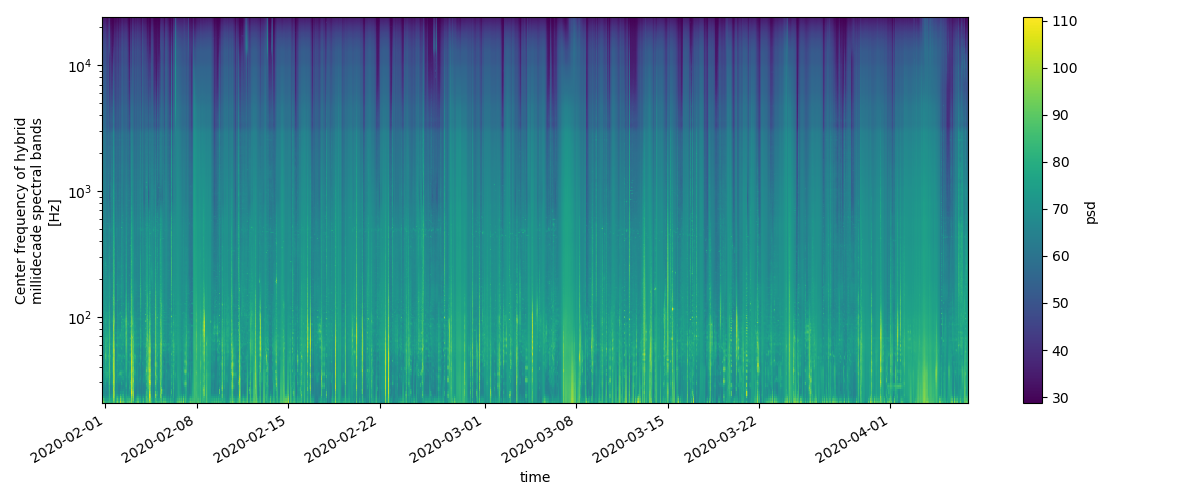

In [44]:
# Plot resampled sound data
ds.psd.plot(x='time', yscale='log')
plt.show()

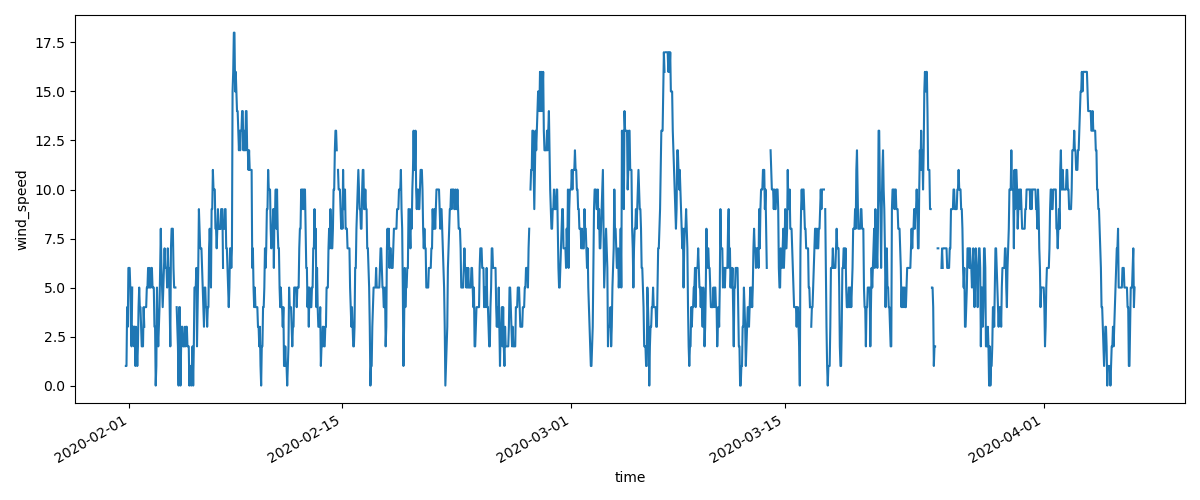

In [128]:
# Plot resampled wind data
ds[wind_var].plot()
plt.show()

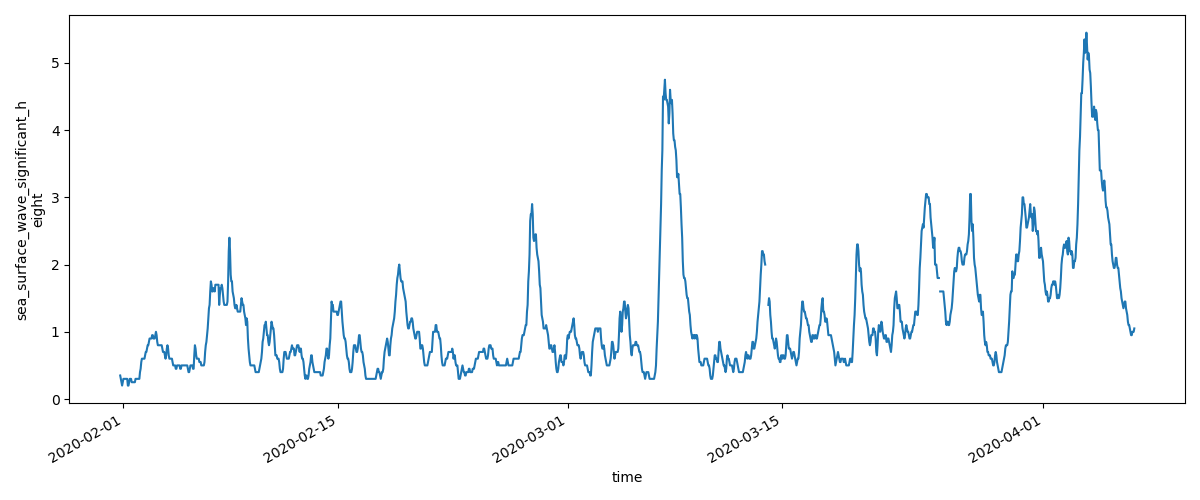

In [130]:
# Plot resampled wave data
ds[wave_var].plot()
plt.show()

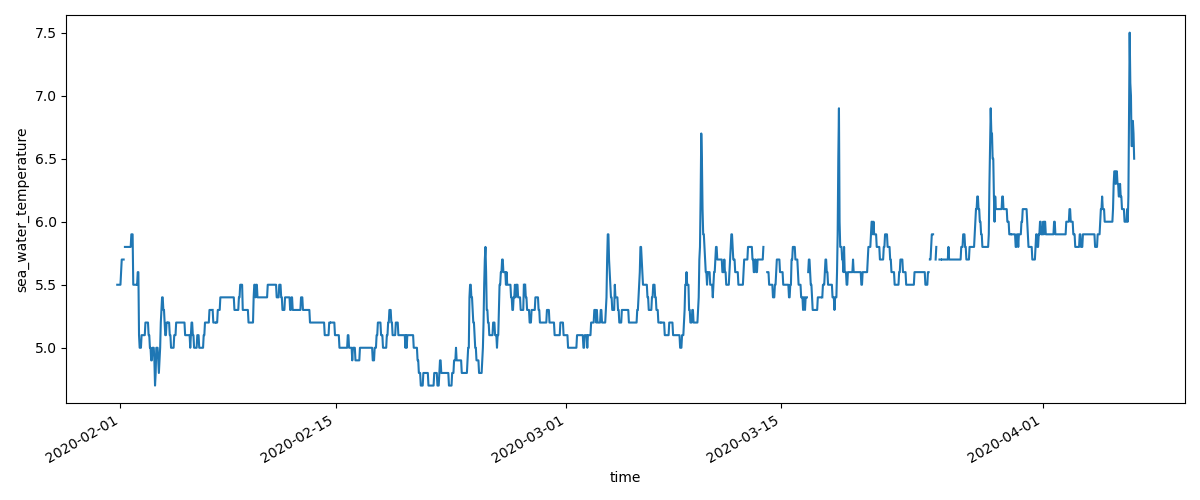

In [47]:
# Plot resampled water temperature data
ds[swt_var].plot()
plt.show()

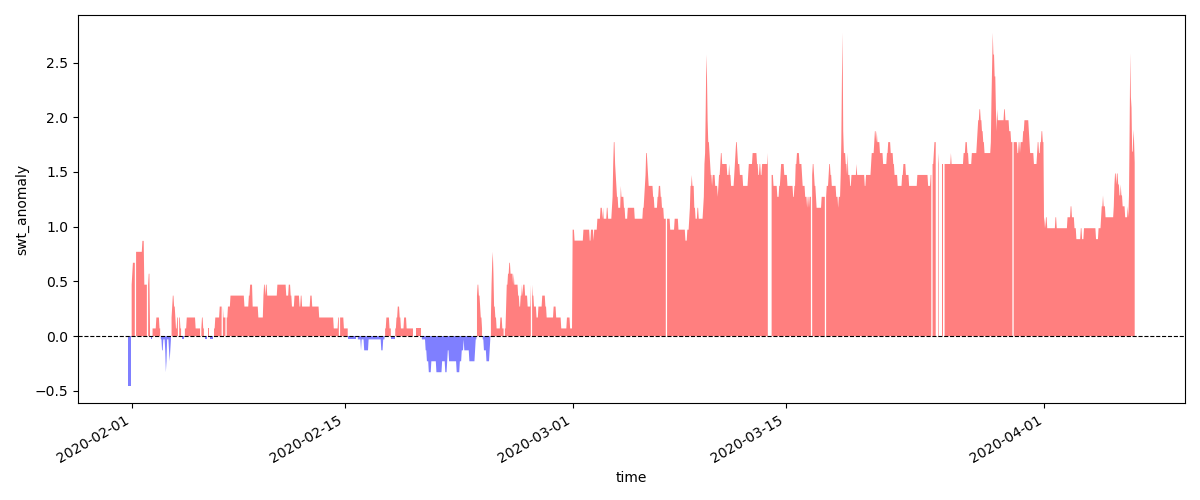

In [48]:
# Plot water temperature anomaly data
ds[anomaly_var].plot(linestyle='')
plt.fill_between(ds.time, ds[anomaly_var], 0, where=(ds[anomaly_var] < 0), facecolor='blue', alpha=0.5)
plt.fill_between(ds.time, 0, ds[anomaly_var], where=(ds[anomaly_var] >= 0), facecolor='red', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.show()

## Plot power spec

In [49]:
def plot_power_spec(
    ds, 
    conditions=None,
    xlabel = 'Frequency (hz)', 
    ylabel = 'Sound pressure level (db)'
):
    """
    Produces power spec plot given zero or more conditions and labels

    Args:
        ds: An Xarray Dataset consisting of both sound and environmental variables.
        conditions (optional): A single tuple or list of tuples, where each tuple is 
            a condition-label pair, the condition representing a conditional statement to
            be passed to ds.where() and each label representing that condition's legend label.
        xlabel (optional): The X-axis label.
        ylabel (optional): The Y-axis label.
    """
    fig, ax = plt.subplots()

    # If no conditions were specified, just plot everything
    if conditions is None:
        ds.psd.median(dim='time').plot(x='frequency', xscale='log', ax=ax)

    else:

        # If conditions is a tuple (i.e. a single condition), wrap it in a list so it's iterable
        if isinstance(conditions, tuple):
            conditions = [conditions]

        # Plot each condition in turn
        for c, l in conditions:

            da = ds.where(c, drop=True).psd

            # Only plot if result of where operation has data
            if len(da) > 0:
                da.median(dim='time').plot(x='frequency', xscale='log', ax=ax, label=l)

        ax.legend()

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.show()


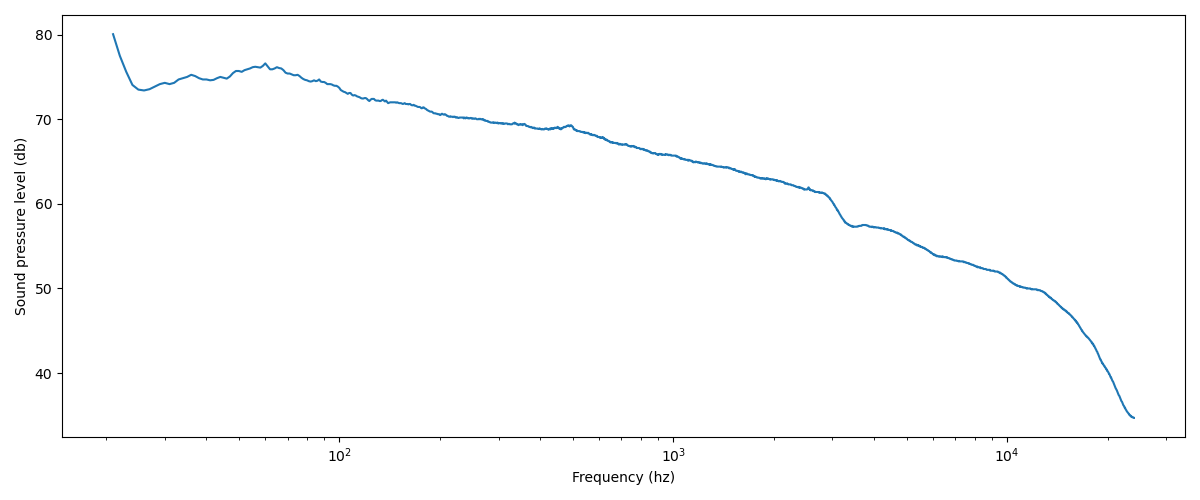

In [139]:
# Plot everything
plot_power_spec(ds)

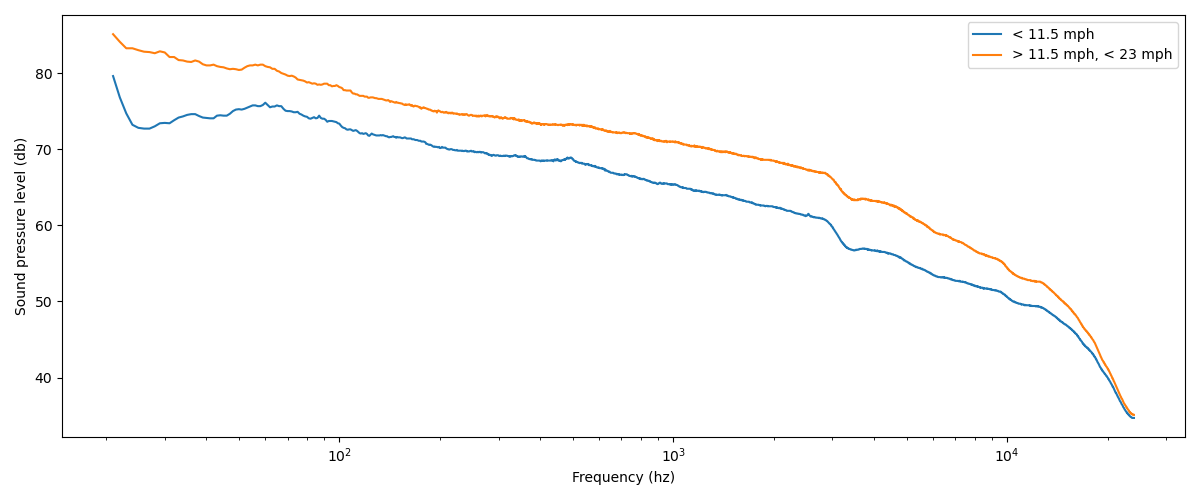

In [141]:
# Plot wind speed intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[wind_var] <= 11.5, '< 11.5 mph'),
        ((ds[wind_var] > 11.5) & (ds[wind_var] <= 23), '> 11.5 mph, < 23 mph'),
        (ds[wind_var] > 23, '> 23 mph')
    ]
)

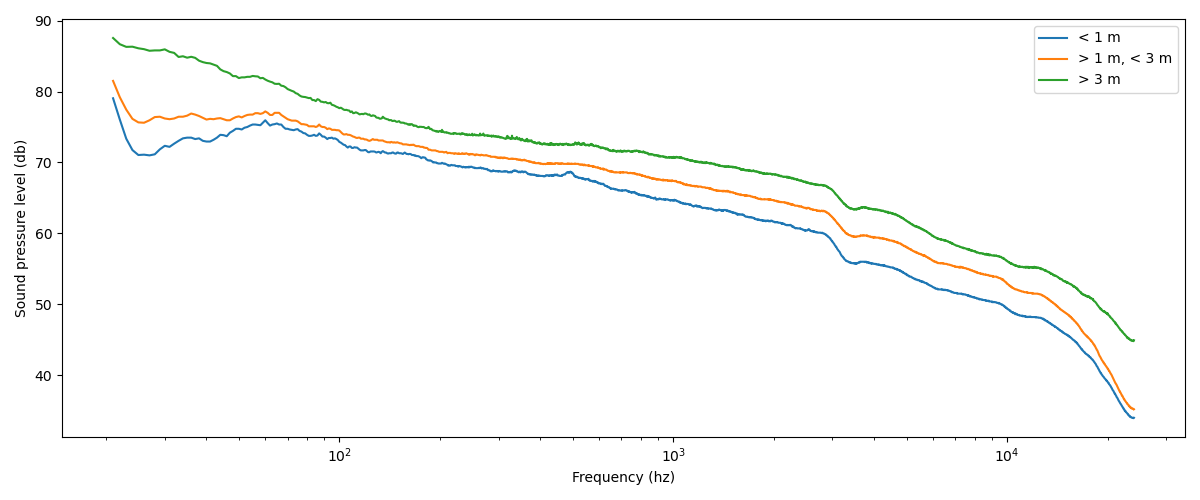

In [142]:
# Plot waves height intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[wave_var] <= 1, '< 1 m'),
        ((ds[wave_var] > 1) & (ds[wave_var] <= 3), '> 1 m, < 3 m'),
        (ds[wave_var] > 3, '> 3 m')
    ]
)

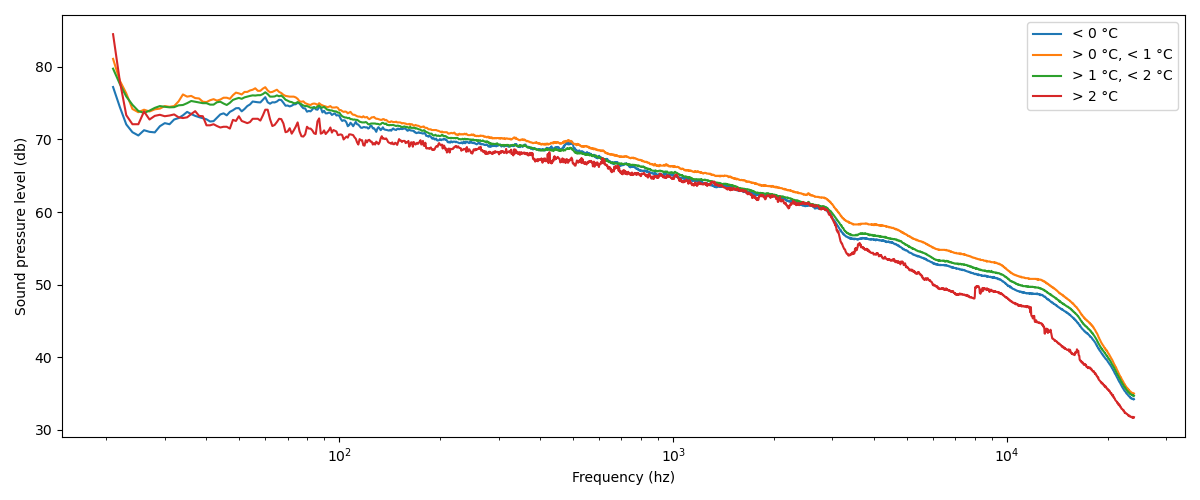

In [53]:
# Plot temperature anomaly intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[anomaly_var] <= 0, '< 0 °C'),
        ((ds[anomaly_var] > 0) & (ds[anomaly_var] <= 1), '> 0 °C, < 1 °C'),
        ((ds[anomaly_var] > 1) & (ds[anomaly_var] <= 2), '> 1 °C, < 2 °C'),
        (ds[anomaly_var] > 2, '> 2 °C')
    ]
)